# Time Series Classification with NN classifiers

In [1]:
require(data.table)
require(ggplot2)
require(repr)
require(rpart)
require(rattle)
require(TSrepr)
require(zoo)

# assuming you have the data folder in your working directory in the following format:
# 'working_directory/ClassificationData/dataset_name/'
current_folder=getwd()
dataset='CBF'

train_data_path=sprintf('%s/ClassificationData/%s/%s_TRAIN.txt',current_folder,dataset,dataset)

traindata=as.matrix(fread(train_data_path))

head(traindata)


Loading required package: data.table

Loading required package: ggplot2

Loading required package: repr

Loading required package: rpart

Loading required package: rattle

Loading required package: tibble

Loading required package: bitops

Rattle: A free graphical interface for data science with R.
Version 5.4.0 Copyright (c) 2006-2020 Togaware Pty Ltd.
Type 'rattle()' to shake, rattle, and roll your data.

Loading required package: TSrepr

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129
1,-0.4642765,-0.5550479,-0.84284310,-0.86589548,-0.9363963,-0.8172700,-0.2636122,-1.25804830,-1.2503934,⋯,-1.3310856,-1.0837000,-1.0179615,-0.9160287,-1.1342892,-0.9202237,-0.7893615,-0.6387058,-0.9636643,-1.24516910
1,-0.8969721,-0.6856855,-1.35138180,-1.45866680,-1.1653456,-1.4039293,-1.8217996,-0.83160109,-1.0163124,⋯,-1.0625534,-1.5686762,-1.3640403,-1.1551774,-0.9958611,-1.1637529,-0.9165233,-0.5820981,-1.2590094,-1.39252410
1,-0.4646960,-0.5677389,-0.03202276,-0.63504562,-0.6028255,-0.2668563,-0.2670613,-0.93104230,-0.4493819,⋯,-0.2867213,-0.6371576,-0.1552602,-0.6881293,-0.8856088,-0.7662393,-0.8653152,-0.2844857,-0.6878891,-0.88760835
3,-0.1871897,-0.6208077,-0.81566070,-0.52139796,-0.7904229,-0.9675174,-1.4870063,-0.27788714,-0.8350747,⋯,-0.9086154,-0.7262865,0.1837776,-0.7374441,-1.1139967,-0.3939866,-0.5878895,-0.6082319,-0.6364646,-0.34902865
2,-1.1360166,-1.3191953,-1.84462380,-0.78869178,-0.2517154,-1.4876032,-0.6687641,-0.34036037,-1.0463815,⋯,-1.1829110,-1.0735136,-1.6113624,-1.0643404,-0.9707364,-0.8272809,-0.9535377,-1.2701854,-1.7427579,-0.92594391
2,-0.5687087,-0.8881180,-0.04797658,-0.03803611,-0.4830683,-1.0946887,-0.9534529,-0.03000688,-0.7954546,⋯,-0.9907398,0.5183746,-0.2285628,-0.5652887,-0.6429980,-1.1094278,-0.1010932,-0.2339490,-0.6198269,-0.08306189


[1]  30 128


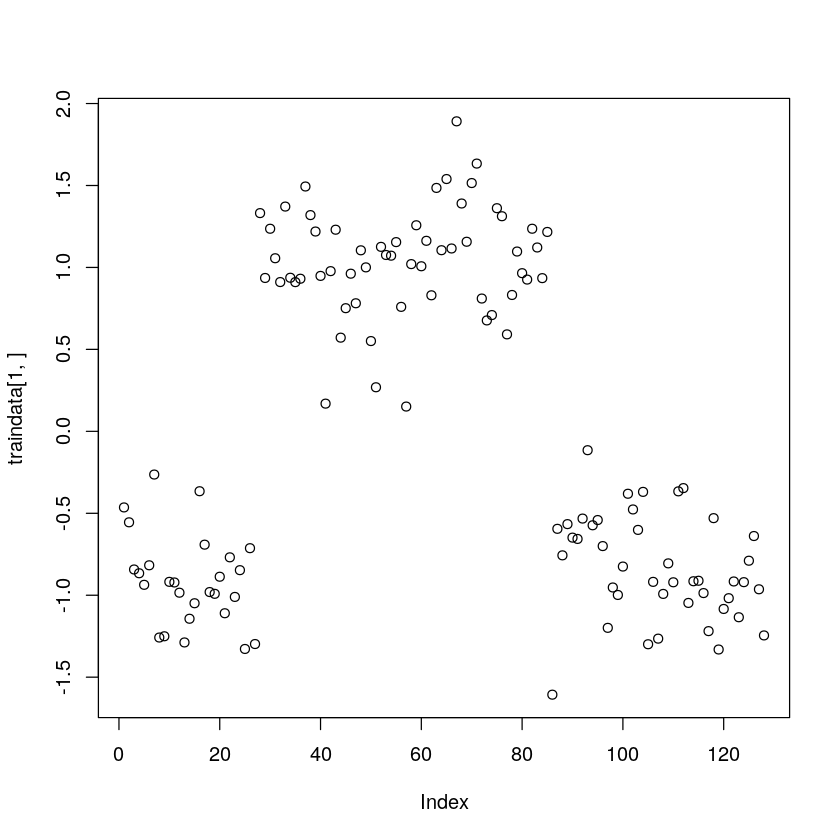

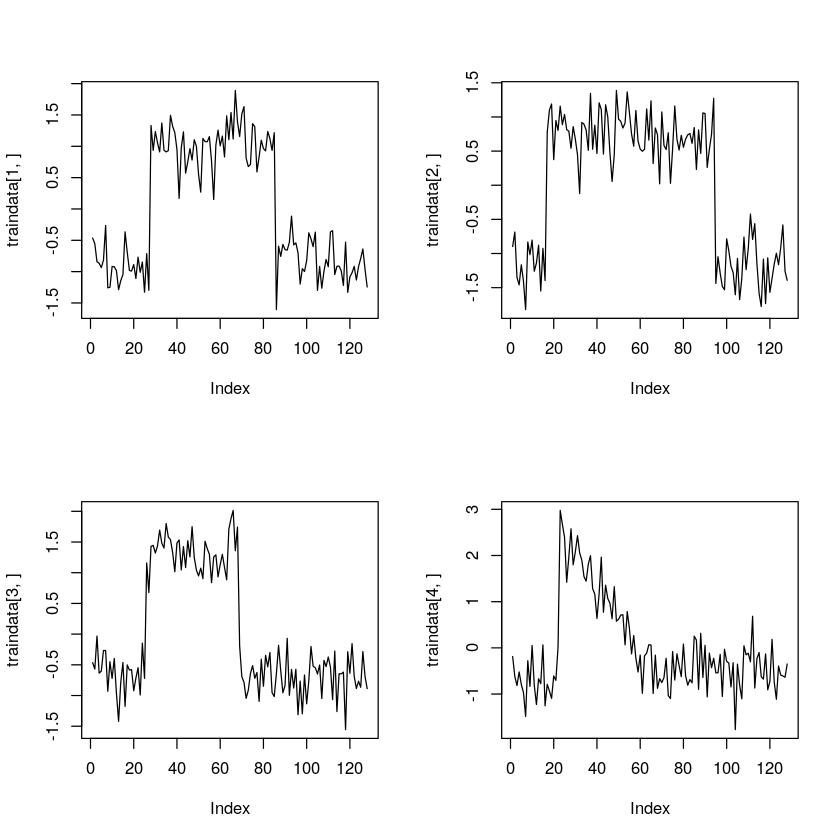

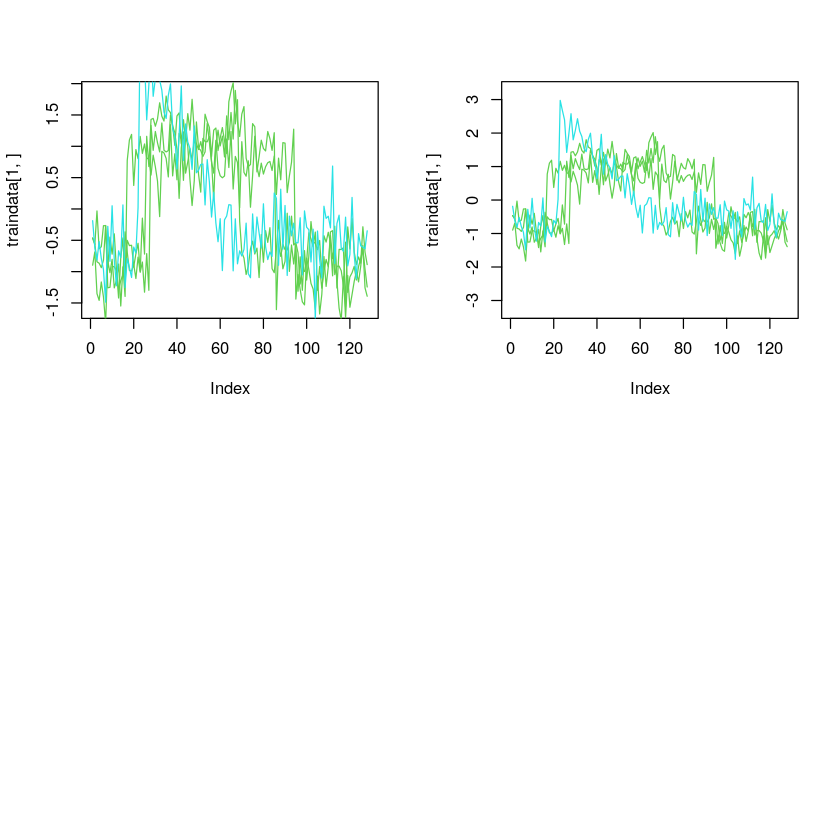

In [2]:
#first column is the class variable
trainclass=traindata[,1] # takes -1 and 1
#drop first column
traindata=traindata[,2:ncol(traindata)]
print(dim(traindata)) #shows that there 100 series (rows) of length 96 time units (columns)

tlength=ncol(traindata)
noftimeseries=nrow(traindata)

#let's plot some of the time series
plot(traindata[1,])
#let's use line format
plot(traindata[1,],type='l')

#multiple plots on single plot
par(mfrow=c(2,2)) #2x2 grid
plot(traindata[1,],type='l')
plot(traindata[2,],type='l')
plot(traindata[3,],type='l')	
plot(traindata[4,],type='l')

#let's plot them overlaid with colors representing their class
plot(traindata[1,],type='l',col=trainclass[1]+2)
points(traindata[2,],type='l',col=trainclass[2]+2)
points(traindata[3,],type='l',col=trainclass[3]+2)	
points(traindata[4,],type='l',col=trainclass[4]+2) 

#problem with limits?
lim=max(abs(traindata[1:4,])) #maximum of the absolute value of the observations for first 4 time series
plot(traindata[1,],type='l',col=trainclass[1]+2,ylim=c(-1.1*lim,1.1*lim))
points(traindata[2,],type='l',col=trainclass[2]+2)
points(traindata[3,],type='l',col=trainclass[3]+2)	
points(traindata[4,],type='l',col=trainclass[4]+2) 


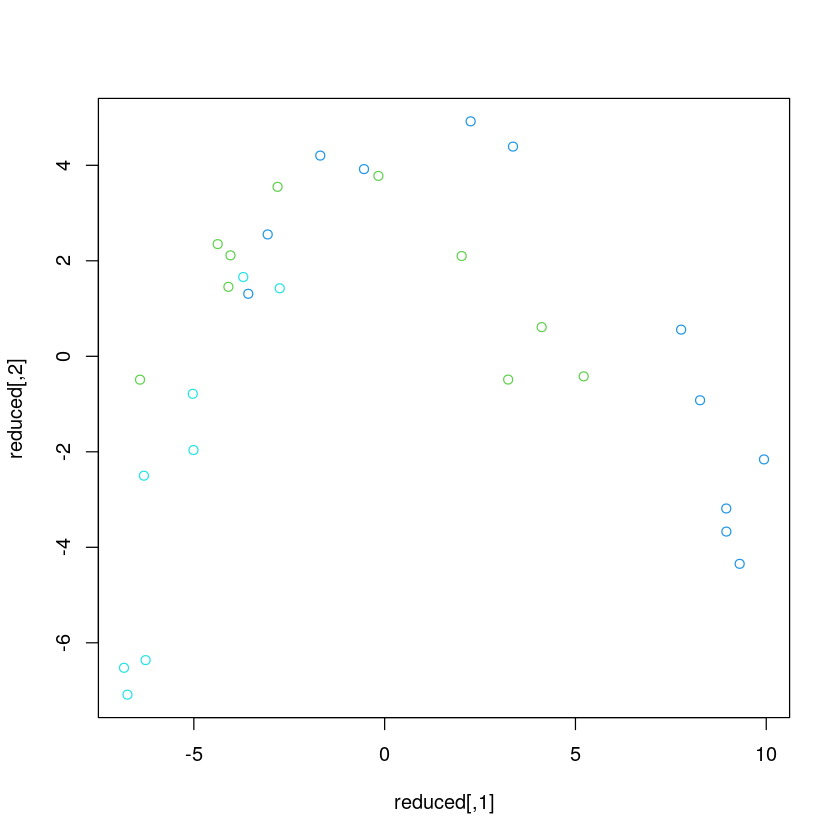

In [3]:
euc_dist=dist(traindata)

euc_dist=as.matrix(euc_dist)
# apply MDS to understand what Euclidean distance reflects
reduced=cmdscale(euc_dist,k=2)
plot(reduced,col=trainclass+2)


In [4]:
head(euc_dist)

,1,2,3,4,5,6,7,8,9,10,⋯,21,22,23,24,25,26,27,28,29,30
1,0.000000,9.449364,9.358967,13.24577,15.84053,11.513919,8.675663,14.20093,11.21629,8.071055,⋯,17.26329,14.15534,9.10022,12.34549,8.045094,10.366692,10.089682,10.419929,9.879613,8.220676
2,9.449364,0.000000,11.016553,11.64415,16.72213,12.470209,7.508033,11.44531,10.98939,7.836692,⋯,18.04283,14.90078,11.64037,14.99946,9.648777,12.158471,11.576478,12.198272,11.205922,9.269198
3,9.358967,11.016553,0.000000,10.73249,17.41313,9.420593,10.199629,12.07478,14.89140,9.532770,⋯,18.94719,16.87893,11.90997,14.46470,9.238307,8.737262,9.744871,7.761067,8.667752,11.430761
4,13.245768,11.644152,10.732494,0.00000,17.78881,14.211284,11.335166,10.32766,16.50792,11.356598,⋯,18.56769,17.90161,14.31722,15.97430,12.241612,11.327443,14.556190,10.151100,11.270617,13.766867
5,15.840525,16.722127,17.413129,17.78881,0.00000,16.714189,16.447398,18.74608,13.40247,16.527378,⋯,11.18996,10.44882,12.49306,11.45392,15.989725,16.795150,16.477706,17.421956,16.348070,14.340903
6,11.513919,12.470209,9.420593,14.21128,16.71419,0.000000,11.778372,14.41449,13.97201,11.761546,⋯,17.49074,16.44923,12.85238,14.52085,11.244422,12.161887,8.756060,11.662135,11.792407,12.399316


In [5]:
# evaluate 1-NN classifier on training data
large_number=1000
diag(euc_dist)=large_number

# check the nearest neighbor for first time series
neighborhood=order(euc_dist[1,]) #first array entry is 1, why?
neighborhood

[1] 25 10 30 16  7 11 23  3  2 29 12 27 26 28 19  9 14 13  6 24  4 20 22  8 18
[26] 15 17  5 21  1

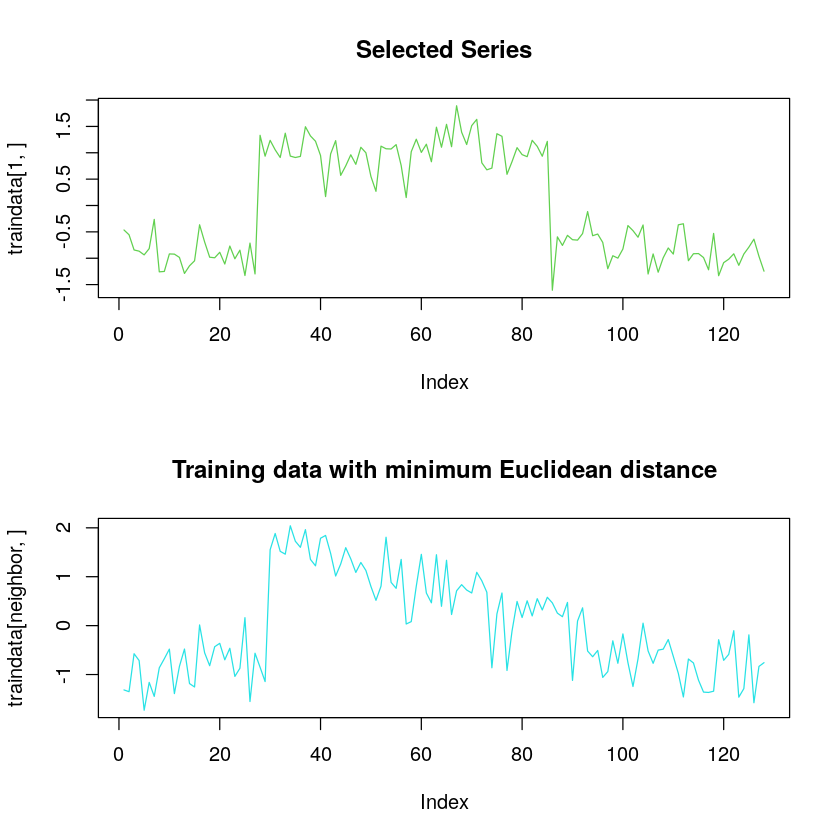

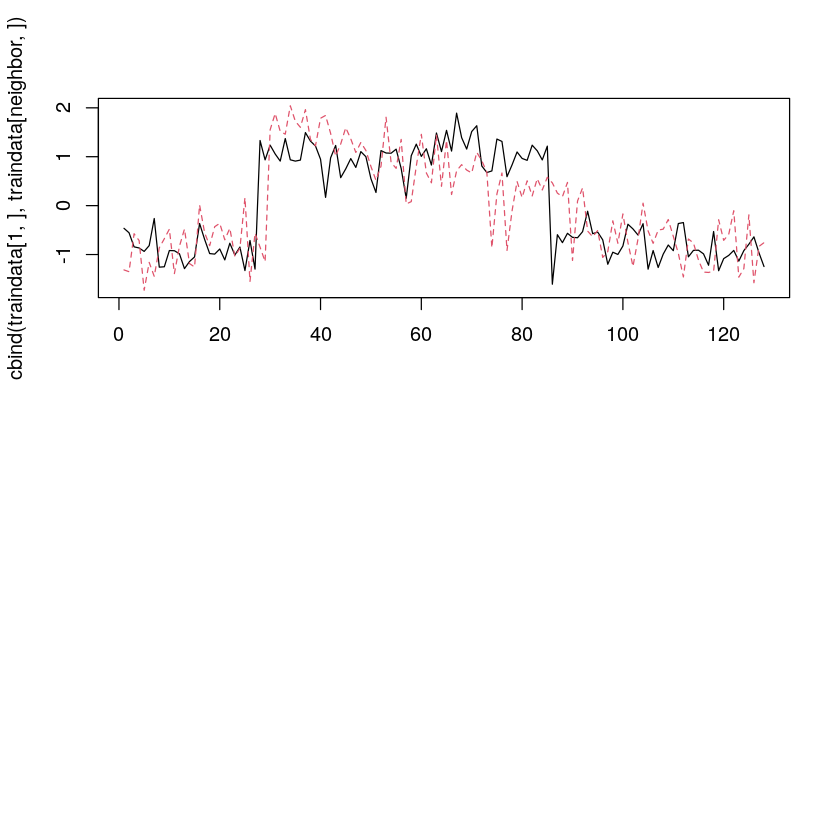

In [6]:
#1-NN
neighbor=neighborhood[1] 
prediction=trainclass[neighbor]

par(mfrow=c(2,1)) #2x1 grid
plot(traindata[1,],type='l',main='Selected Series',col=trainclass[1]+2)
plot(traindata[neighbor,],type='l',main='Training data with minimum Euclidean distance',col=trainclass[neighbor]+2)


matplot(cbind(traindata[1,],traindata[neighbor,]),type='l')

In [7]:
neighborhood=apply(euc_dist,1,order) #first array entry is 1, why?
#neighborhood

predicted=trainclass[neighborhood[1,]]

table(trainclass,predicted)

acc=sum(trainclass==predicted)/length(predicted)
print(acc)

          predicted
trainclass  1  2  3
         1  8  0  2
         2  1 11  0
         3  2  0  6

[1] 0.8333333


## DTW distance



In [8]:
require(dtw)
#require(TSdist)

alignment=dtw(traindata[1,],traindata[2,],keep=TRUE)


Loading required package: dtw

Loading required package: proxy


Attaching package: ‘proxy’


The following objects are masked from ‘package:stats’:

    as.dist, dist


The following object is masked from ‘package:base’:

    as.matrix


Loaded dtw v1.22-3. See ?dtw for help, citation("dtw") for use in publication.




In [9]:
str(alignment)

List of 20
 $ costMatrix        : num [1:128, 1:128] 0.433 0.775 0.829 0.86 0.899 ...
 $ directionMatrix   : int [1:128, 1:128] NA 3 3 3 3 3 3 3 3 3 ...
 $ stepPattern       : 'stepPattern' num [1:6, 1:4] 1 1 2 2 3 3 1 0 0 0 ...
  ..- attr(*, "npat")= num 3
  ..- attr(*, "norm")= chr "N+M"
 $ N                 : int 128
 $ M                 : int 128
 $ call              : language dtw(x = traindata[1, ], y = traindata[2, ], keep.internals = TRUE)
 $ openEnd           : logi FALSE
 $ openBegin         : logi FALSE
 $ windowFunction    :function (iw, jw, ...)  
 $ jmin              : int 128
 $ distance          : num 42.2
 $ normalizedDistance: num 0.165
 $ index1            : num [1:205] 1 2 3 4 5 6 6 7 8 8 ...
 $ index2            : num [1:205] 1 1 1 1 1 1 2 2 3 4 ...
 $ index1s           : num [1:205] 1 2 3 4 5 6 6 7 8 8 ...
 $ index2s           : num [1:205] 1 1 1 1 1 1 2 2 3 4 ...
 $ stepsTaken        : int [1:204] 3 3 3 3 3 2 3 1 2 1 ...
 $ localCostMatrix   : 'crossdist' num [1:

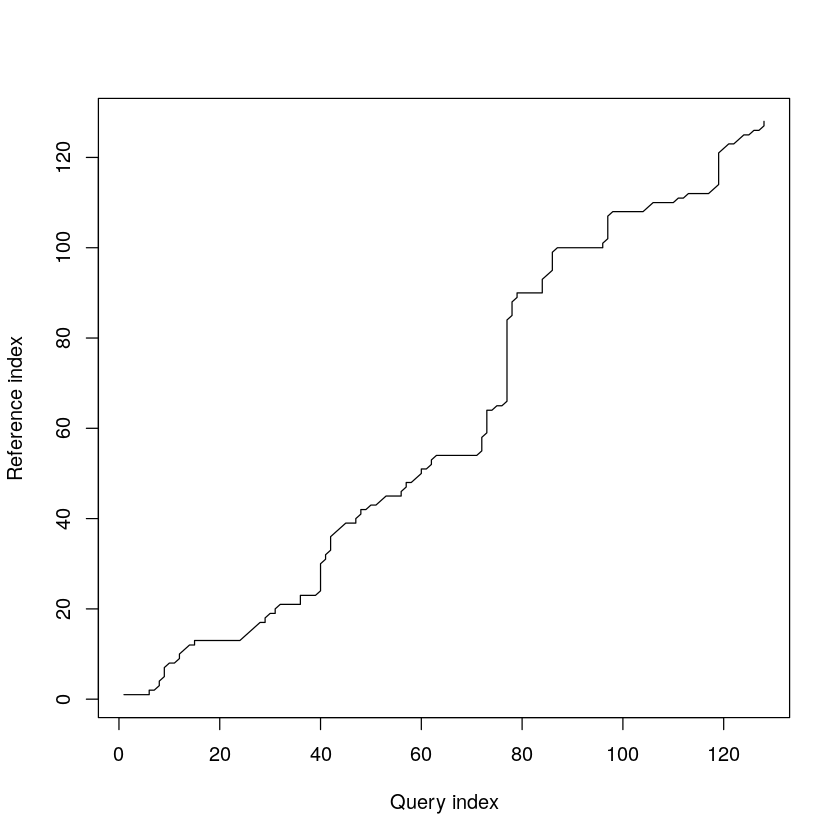

In [10]:
plot(alignment)

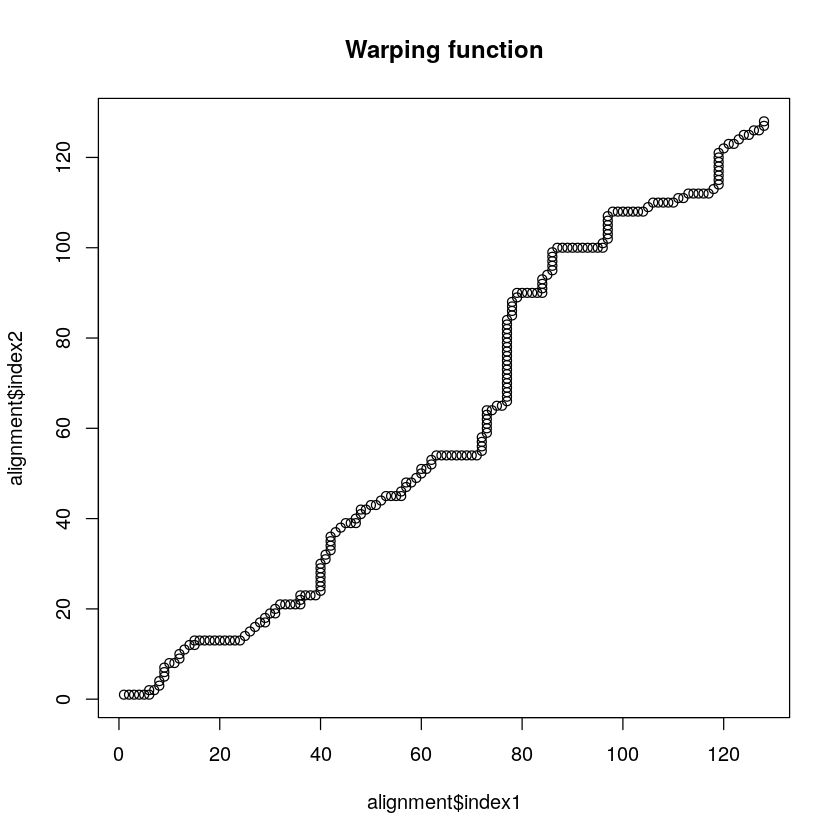

In [11]:
plot(alignment$index1,alignment$index2,main="Warping function")

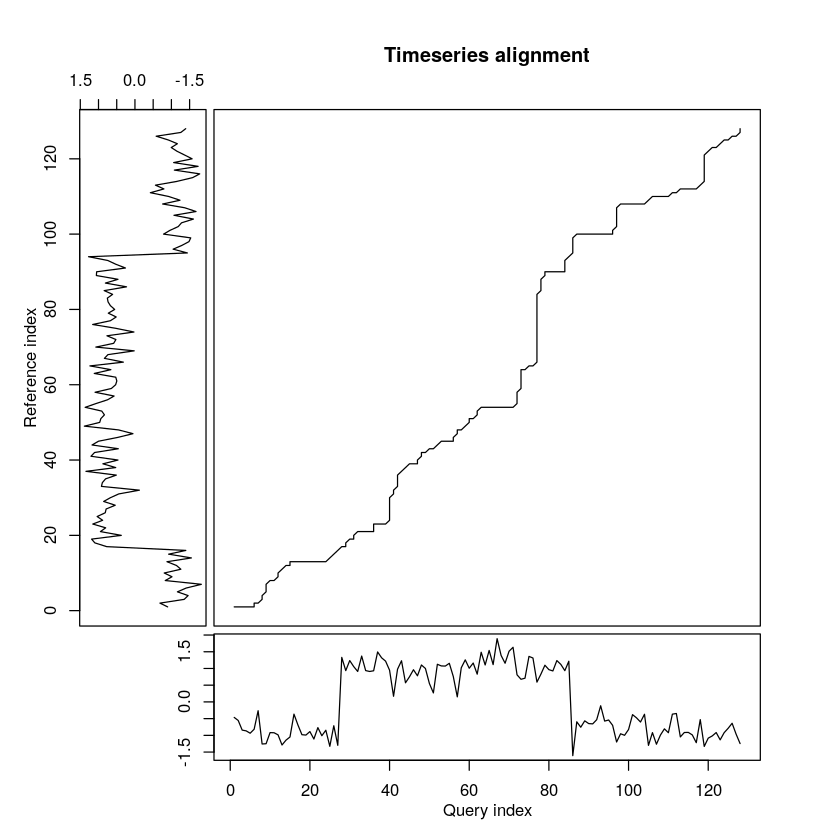

In [12]:
dtwPlotThreeWay(alignment)


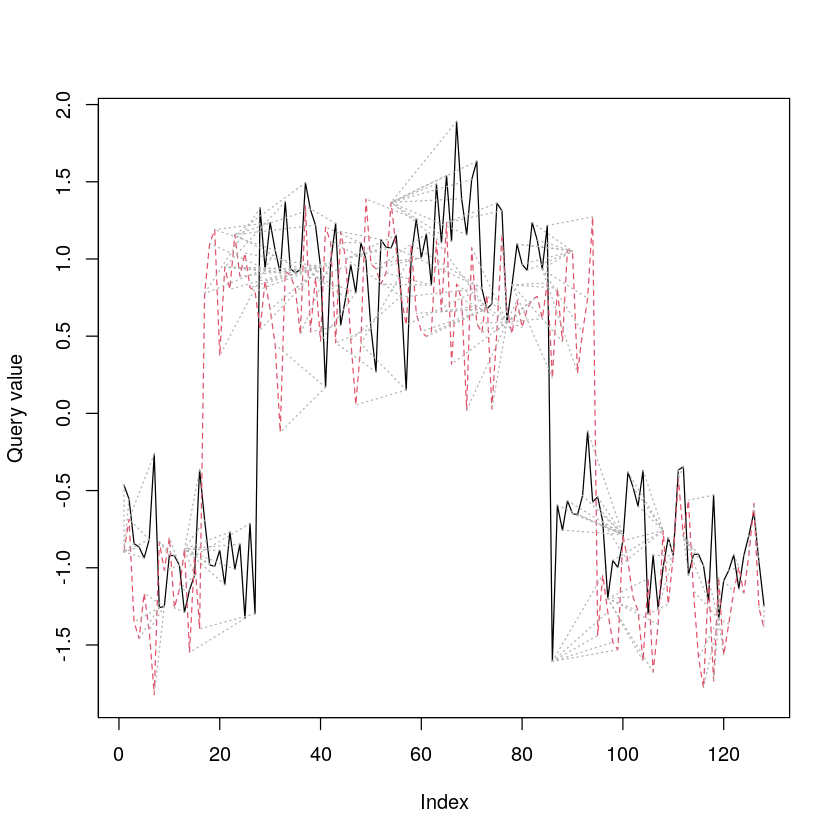

In [13]:
dtwPlotTwoWay(alignment);

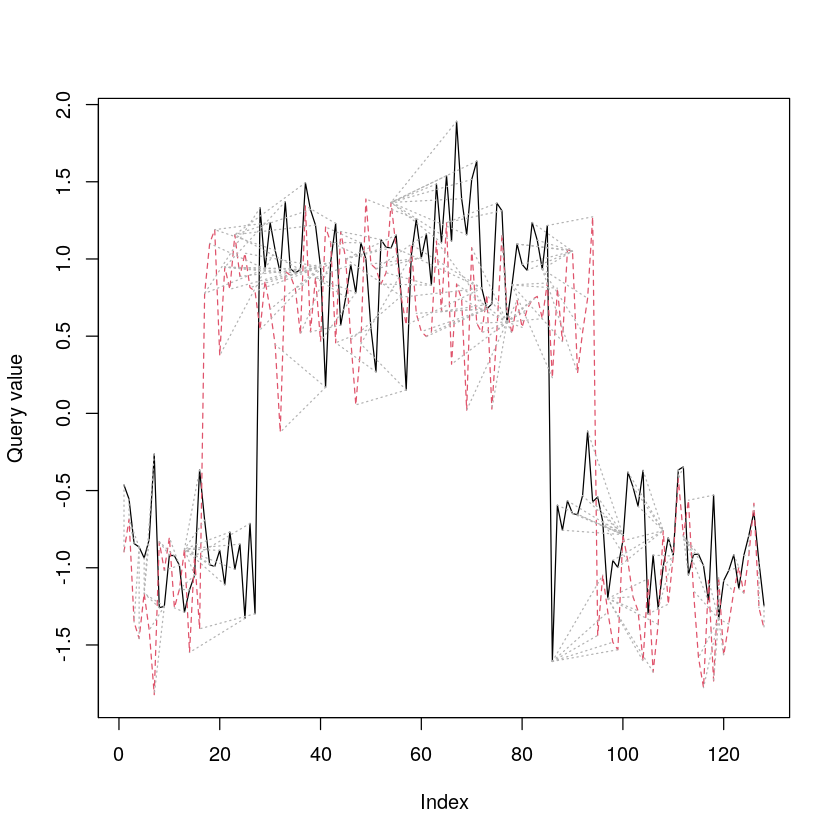

In [14]:
query_ts=traindata[1,]
reference_ts=traindata[2,]
alignment=dtw(query_ts,reference_ts,window.type='itakura',keep=TRUE); 
dtwPlotTwoWay(alignment);

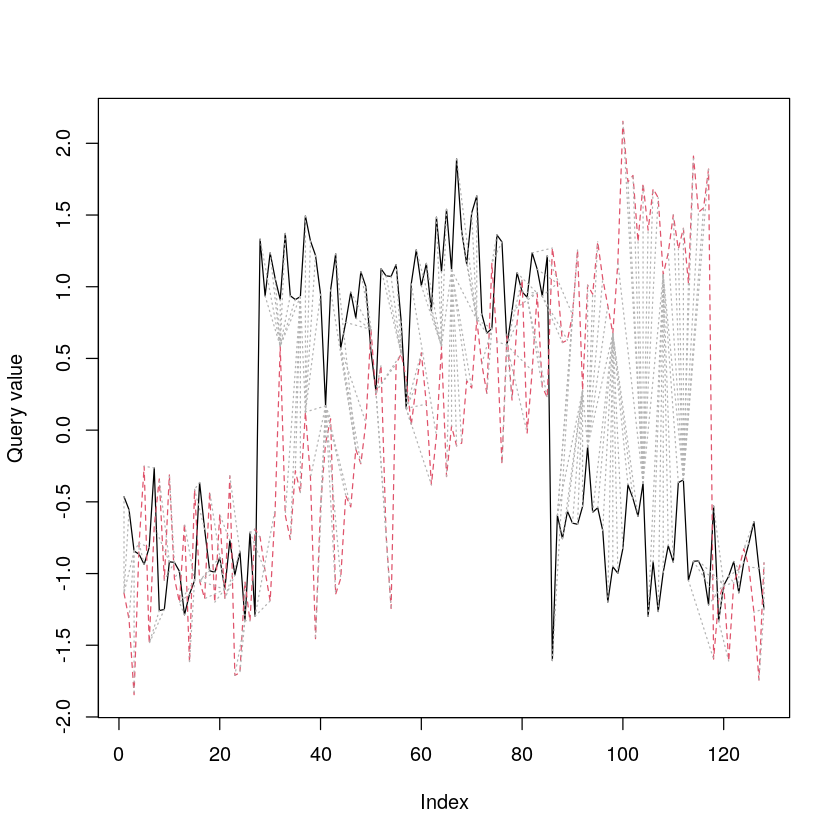

In [15]:
query_ts=traindata[1,]
reference_ts=traindata[5,]
alignment=dtw(query_ts,reference_ts,window.type='sakoechiba',keep=TRUE,window.size=5); 
dtwPlotTwoWay(alignment);

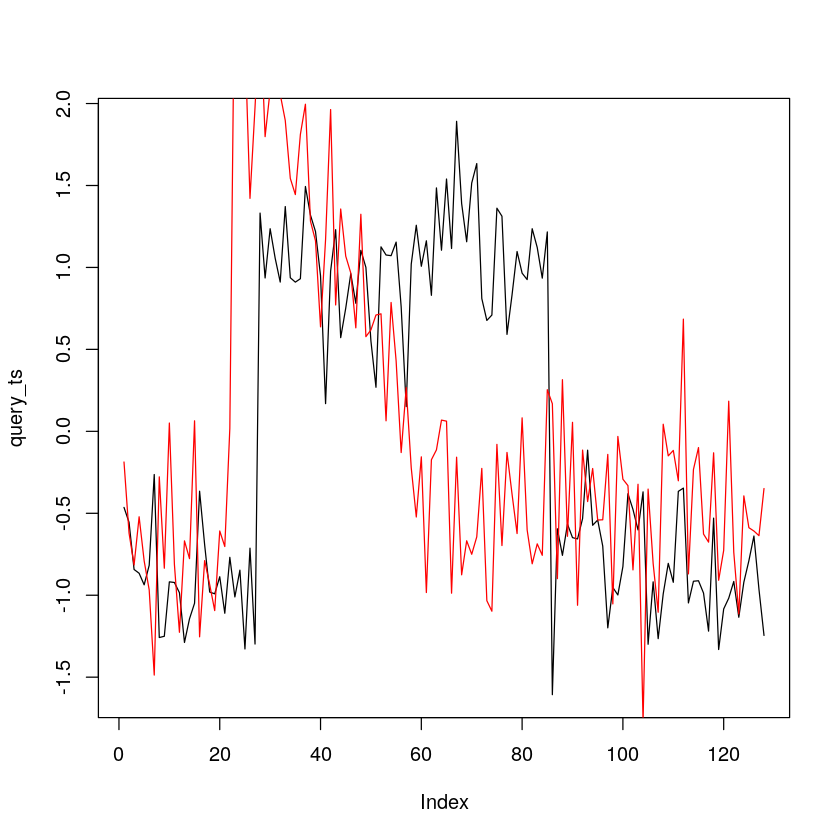

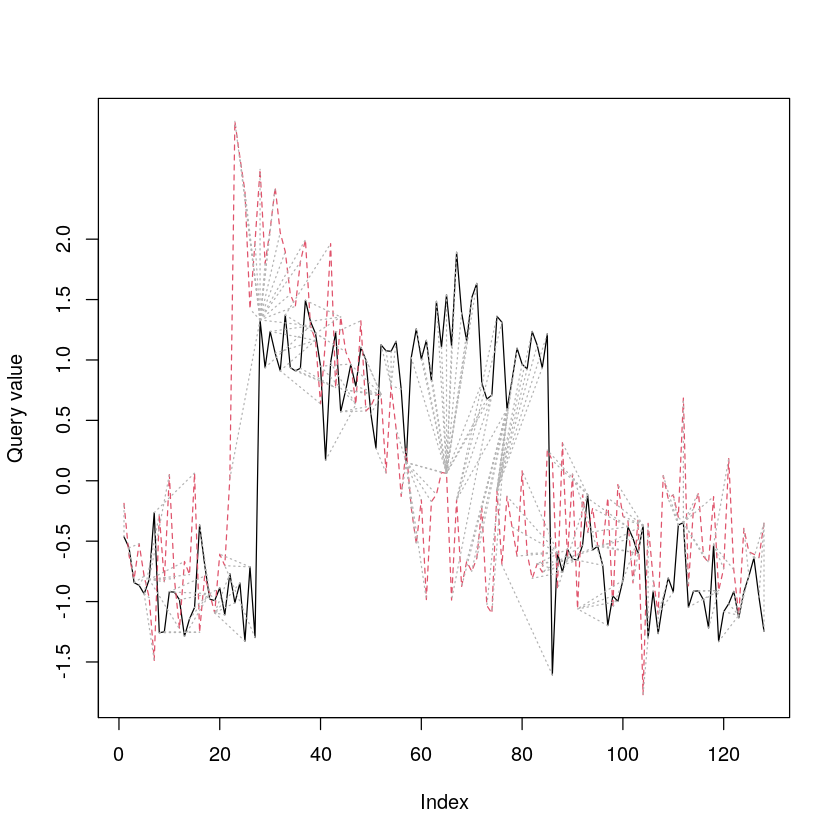

In [16]:
query_ts=traindata[1,]
reference_ts=traindata[4,]

plot(query_ts,col='black',type='l')
points(reference_ts,col='red',type='l')

alignment=dtw(query_ts,reference_ts,window.type='sakoechiba',keep=TRUE,window.size=10); 
dtwPlotTwoWay(alignment);

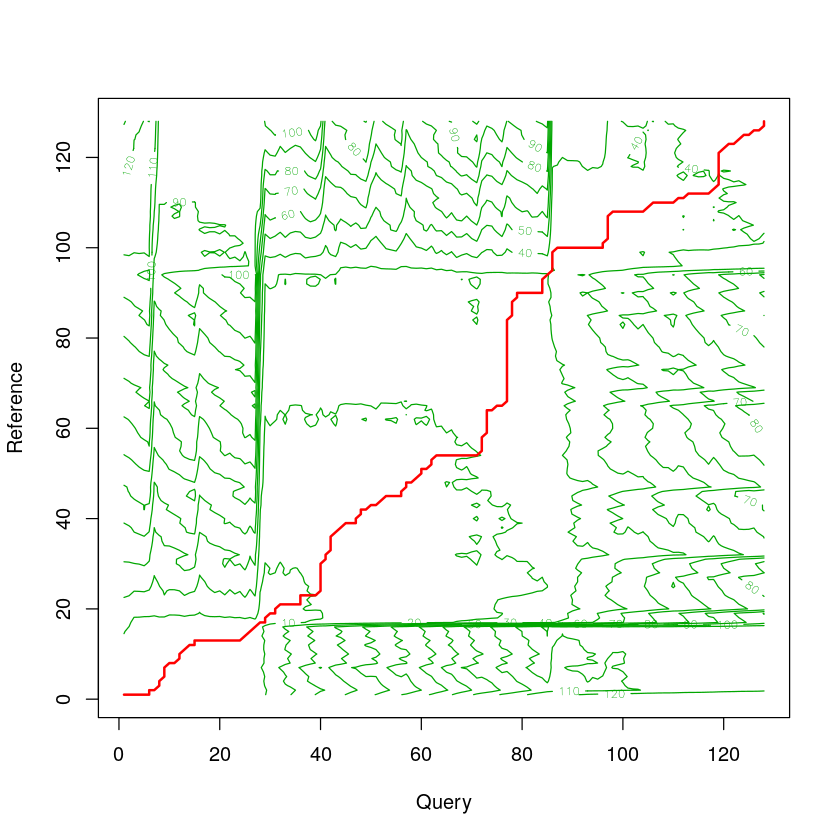

In [17]:

query_ts=traindata[1,]
reference_ts=traindata[2,]

query_length=length(query_ts)
ref_length=length(reference_ts)
alignment=dtw(query_ts,reference_ts,keep=TRUE)
contour(alignment$costMatrix,col=terrain.colors(length(traindata)),x=1:query_length,y=1:ref_length,
xlab="Query",ylab="Reference");
lines(alignment$index1,alignment$index2,col="red",lwd=2);

In [18]:
dtw_dist_mat=dtwDist(traindata)

In [19]:
str(dtw_dist_mat)

 num [1:30, 1:30] 0 42.2 43 68 63.6 ...


In [20]:
diag(dtw_dist_mat)=large_number

neighborhood=apply(dtw_dist_mat,1,order) #first array entry is 1, why?
neighborhood[1,]


[1] 10 19  1 26 17 11 30 26 14 30 14 14 24  9  5 25 22 17  2 26 17 17 19 13 16
[26]  4 14 16  8  2

In [21]:
predicted=trainclass[neighborhood[1,]]

table(trainclass,predicted)

acc=sum(trainclass==predicted)/length(predicted)
print(acc)

          predicted
trainclass  1  2  3
         1 10  0  0
         2  0 12  0
         3  0  0  8

[1] 1


In [22]:
dtw_dist_mat=dtwDist(traindata,window.type='sakoechiba',window.size=5)
diag(dtw_dist_mat)=large_number

neighborhood=apply(dtw_dist_mat,1,order) #first array entry is 1, why?
#neighborhood

predicted=trainclass[neighborhood[1,]]

table(trainclass,predicted)

acc=sum(trainclass==predicted)/length(predicted)
print(acc)

          predicted
trainclass  1  2  3
         1  9  0  1
         2  0 12  0
         3  0  0  8

[1] 0.9666667


In [23]:
dtw_dist_mat=dtwDist(traindata,window.type='itakura')
diag(dtw_dist_mat)=large_number

neighborhood=apply(dtw_dist_mat,1,order) #first array entry is 1, why?
#neighborhood

predicted=trainclass[neighborhood[1,]]

table(trainclass,predicted)

acc=sum(trainclass==predicted)/length(predicted)
print(acc)

          predicted
trainclass  1  2  3
         1 10  0  0
         2  1 11  0
         3  0  0  8

[1] 0.9666667
